# DogsCats

$\textbf{Data Source}$: 
Kaggle Dogs vs. Cats Competition https://www.kaggle.com/c/dogs-vs-cats

$\textbf{Data Preparation}$:
To run this Jupyter Notebook, download data from Kaggle Website and unzip image folders 'train.zip' and 'test1.zip'. Then place resulting folders 'train' and 'test1' in the 'DogsCats' directory of your cloned version of the NeuralNetworkLibrary repository.

NOTE: The directory 'DogsCats' in the GitHub repository also contains two csv files 'train.csv' and 'valid.csv', which will be used in training. These files give the same train-valid split for images from the train folder as the Fastai 2018 Lecture 1 Notebook.

$\textbf{Objective}$:
Image Classification - Identify whether each image is a dog or a cat.

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports
import sys
sys.path.append("../")
from Applications.Vision import *

### Quick Look at the Data

First let's look at the images. 

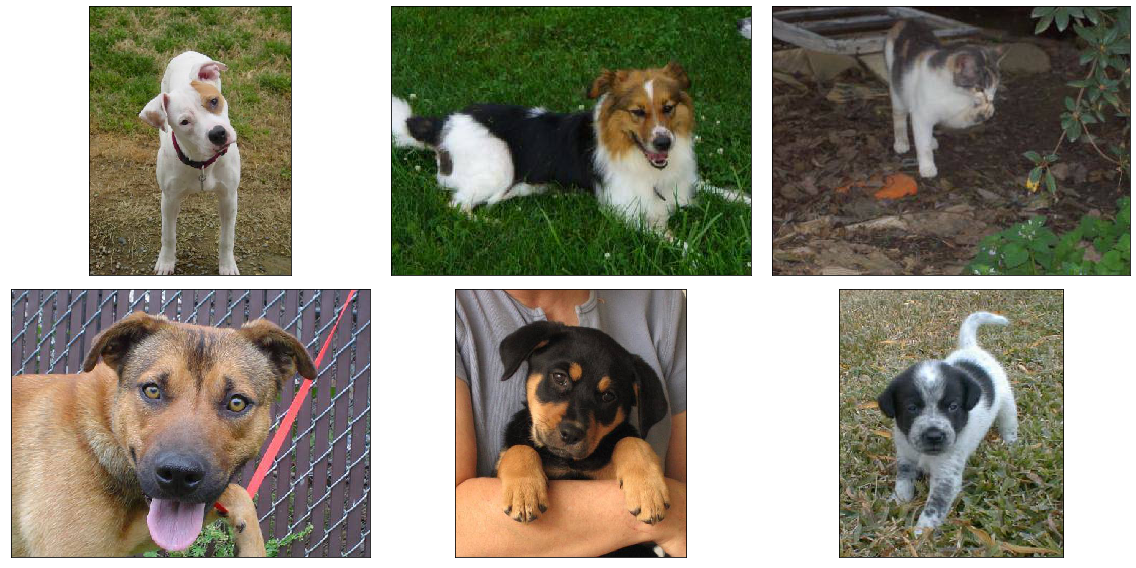

In [2]:
# Images chosen randomly from training folder
ShowImages_from_folder('DogsCats/train')

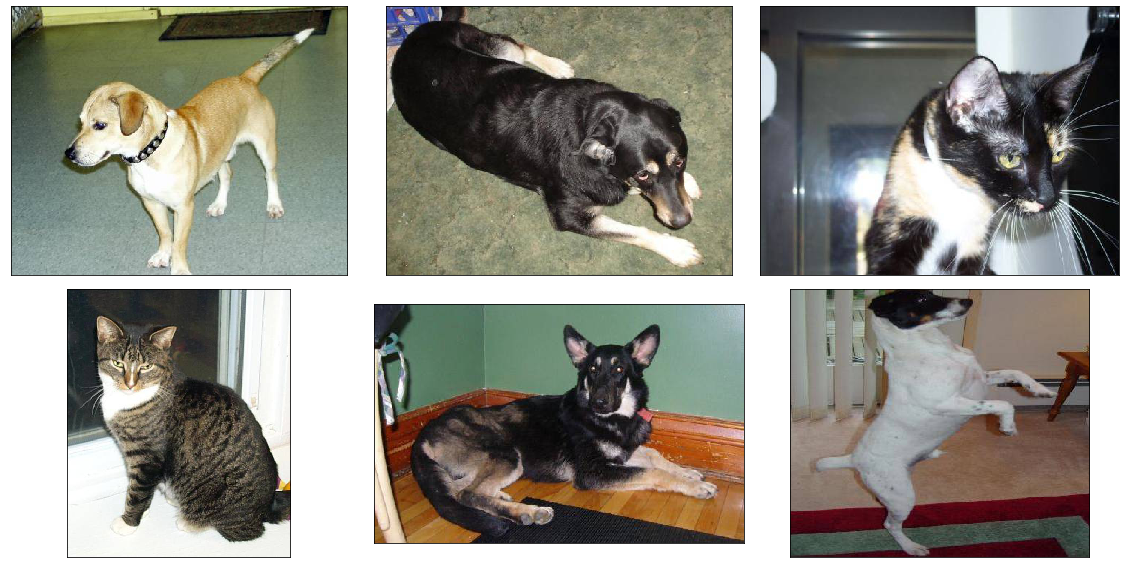

In [3]:
# Images chosen randomly from test folder
ShowImages_from_folder('DogsCats/test1')

Now let's look at some basic properties of the dataset.

In [4]:
# red,green,blue means and stds (per pixel)
train_means, train_stds = get_stats('DogsCats/train')
test_means, test_stds = get_stats('DogsCats/test1')

print('imagnet_means =',imagenet_stats[0], 'imagnet_stds =', imagenet_stats[1])
print('train_means =',np.round(train_means,3), 'train_stds =', np.round(train_stds,3))
print('test_means =',np.round(test_means,3), 'test_stds =', np.round(test_stds,3))


imagnet_means = [0.485 0.456 0.406] imagnet_stds = [0.229 0.224 0.225]
train_means = [0.488 0.455 0.417] train_stds = [0.263 0.257 0.259]
test_means = [0.488 0.457 0.417] test_stds = [0.261 0.254 0.257]


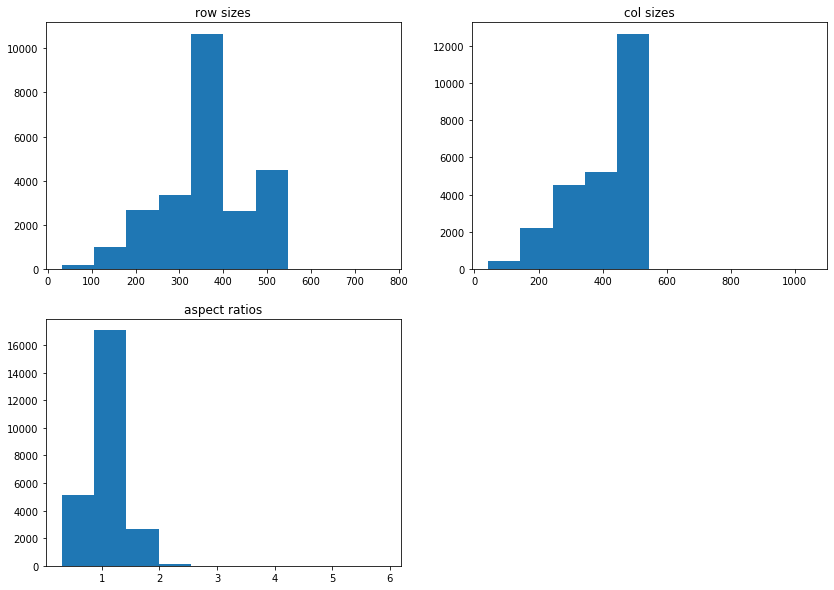

In [5]:
# Histograms of img shapes for train images
plot_imgsize_histograms('DogsCats/train')

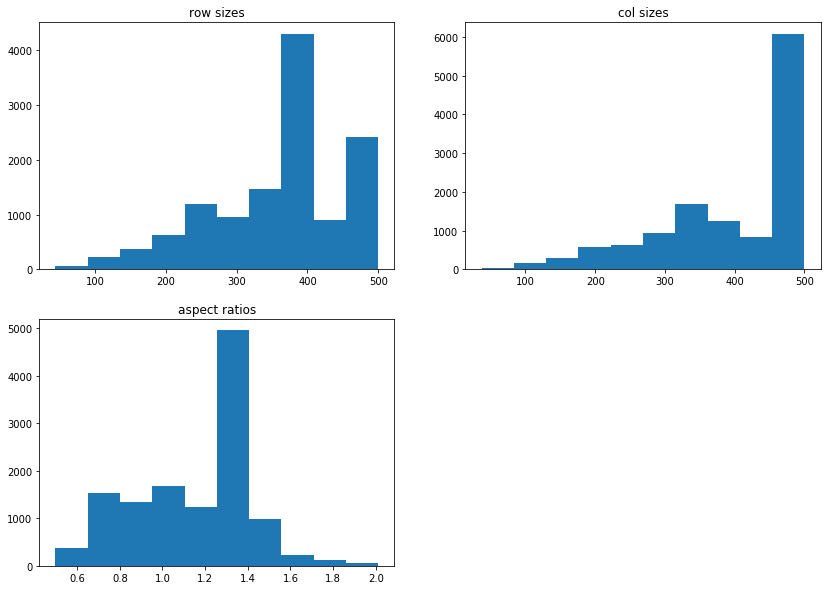

In [6]:
# Histograms of image shapes for test data
plot_imgsize_histograms('DogsCats/test1')

In [7]:
# Number of images of each category in training data
get_cat_counts('DogsCats/train.csv',plot_hist=False)

category  count
0      cat  11500
1      dog  11500

In [8]:
# Number of images of each category in validation data
get_cat_counts('DogsCats/valid.csv',plot_hist=False)

category  count
0      dog   1000
1      cat   1000

Observations: 
1. Training and validation data are both balanced (i.e. equal number of cats and dogs).
1. Red/Green/Blue means and stds of images are pretty close to imagenet. 
2. Images are of 'normal size', mostly between 100-500 pixels in width and height.
3. Image aspect ratios are not very large, mostly in range [0.5,2]

So, basically, this is a pretty standard image classification dataset, and we should not need to do anything too special. Finetuning a pre-trained imagenet model should work well, with standard image augmentations in training. 

### Define DataObj, Model, and Learner

#### DataObj

First we define the DataObj. This object, called $\textbf{data}$, includes the datasets and corresponding dataloaders for train, validation, and test data.

In [9]:
PATH = 'DogsCats/'
transforms = get_transforms(tfm_type='SideOn',sz=224)
data = ImageDataObj.from_csv(PATH, transforms, bs=64, train_csv='train.csv', val_csv='valid.csv', 
                             train_name='train', val_name='train', test_name='test1', target_type='single_label')

Note on transforms:
1. All images are resized to (height,width) = (sz,sz).
2. There are 3 possibilities for the first argument tfm_type: 'SideOn','TopDown', or 'Basic'. <br>
$\bullet$ 'SideOn': In training, images are randomly flipped horizontally left to right. <br>
$\bullet$ 'TopDown': In training, images are randomly flipped horizontally and randomly rotated by 0, 90, 180, or 270 degrees (8 possible dihedral transforms). <br>
$\bullet$ 'Basic': No random left/right flip or random rotation by 90, 180, or 270 degrees.


The 'SideOn' transforms should be used for most images of everyday things like dogs, cats, chairs, people, ...etc. These things could just as easily be seen flipped left to right, but would not usually be seen in a position as extremely rotated as 90 or 180 degrees. 

The 'TopDown' transforms should be used for most types of images taken from above, e.g. satellite images or cells in a petri dish. These things could generally be just as easily seen flipped left to right or rotated by any angle. 

The 'Basic' transforms should be used for images where both flipping and significant rotation could create a 'mis-representation' of the object. Probably the best example of this is written letters or numbers, which should be in only 1 orientation.

#### Arch

Now, we select a pretrained architecture to use as the backbone of our model.

Because this is a simple classification problem with only 2 (fairly distinct looking) classes, 
we will use only a resnet34 architecture. Using one of the larger/more advanced architectures
(commented out below) may give slightly better results, at the cost of longer training times.

In [10]:
arch = models.resnet34(pretrained=True)
#arch = models.resnet50(pretrained=True)
#arch = models.resnet101(pretrained=True)
#arch = vmods.resnext101_64x4d()
#arch = vmods.inceptionresnetv2()
#arch = vmods.inceptionv4()
#arch = vmods.senet154()
#arch = vmods.se_resnet101()
#arch = vmods.se_resnext101_32x4d()
#arch = vmods.nasnetalarge()

#### Model and Learner

Finally, we define our $\textbf{model}$ and $\textbf{learner}$ objects. 

The object $\textbf{model}$ is a pytorch model of the neural network (i.e. a nn.Module). This object is created by removing the final classification layer from the pre-trained arch, and replacing it with a new 'head' component as the classifier. This head component has outputs corresponding to the number of classes for our data object $\textbf{data}$. By default, the head component is a 2 layer fully connected network, which includes dropout and batchnorm. However, a custom head module may also be specified by the user.

The object $\textbf{learner}$ is of class ImageLearner from the file Vision.py, which inherits from the class Learner in the file Learner.py. In general, the Learner class always combines a pytorch neural network model ($\textbf{model}$) along with a data object ($\textbf{data}$) and the optimizer and loss function for training. This class has a large number of methods for training and evaluating models, making precictions, and other useful things.

In [11]:
model = ImageClassificationNet(data,arch)
learner = ImageLearner(PATH,data,model)

Note that when initializing the learner object: 
1. The default optimizer is SGD with momentum of 0.9, but other optimizers can be specified. The Adam optimizer is used in several of the other notebooks. 
2. If the loss function is not specified, a default loss function is chosen suitable for the data type. For single-label classification problems, like this one, the default loss function is nn.CrossEntropyLoss().

### Training

#### Step 1: 
Freeze all layers in the resnet backbone, and tune only the 'head' component of our model. 

We will also use bn_freeze(). This makes it so that, for batchnorm layers in the backbone, the moving avg of the mean and std are not updated during training, but instead remain the moving avg from imagenet training. This is often useful to do when training with the backbone frozen, especially if the underlying data is of things that look similar to imagenet photos. 

In [12]:
learner.freeze()
learner.bn_freeze()

Now, before training, we use the learner.find_lr() method to select a good learning rate, 
generally about a factor of 5-10 below minimum of learning rate curve.

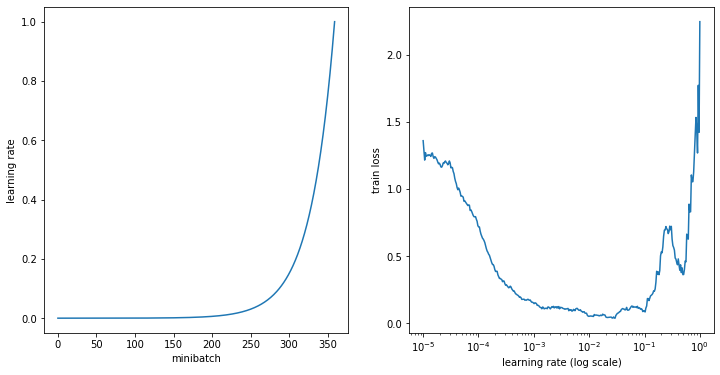

In [13]:
learner.find_lr()

In [14]:
# Fit 2 epochs with constant learning rate
lr = 0.005
learner.fit(lr,2)

epoch   train_loss  val_loss    accuracy    

0       0.05871     0.03235     0.99050       epoch run time: 1 min, 6.05 sec
1       0.04720     0.03222     0.98900       epoch run time: 1 min, 4.31 sec


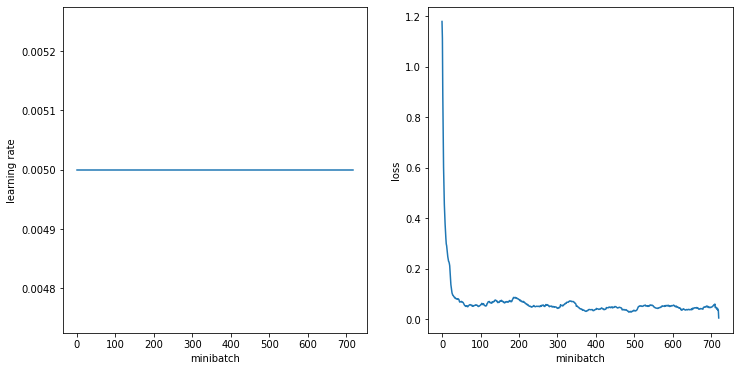

In [15]:
# Plot lr and loss schedule for this training period
learner.plot_lr_and_loss_sched(smoothing_radius=20)

In [16]:
# Fit for 2 cycles, each of length 1 epoch
learner.fit_cycles(lr_start=lr,lr_end=lr/1e4,num_cycles=2)

epoch   train_loss  val_loss    accuracy    

0       0.04172     0.03025     0.99000       epoch run time: 1 min, 6.02 sec
1       0.03793     0.03150     0.98800       epoch run time: 1 min, 5.99 sec


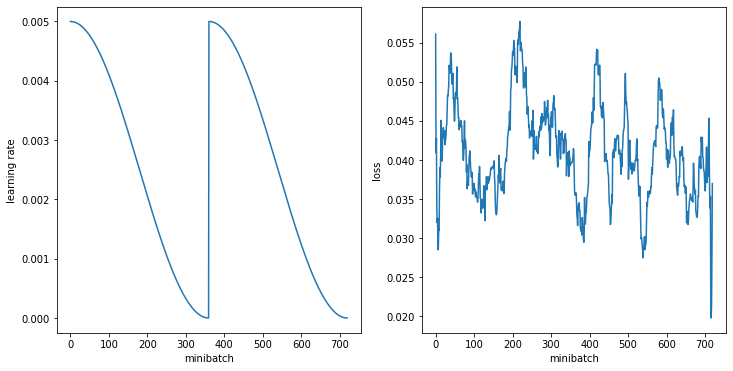

In [17]:
# Plot lr and loss schedule for this training period
learner.plot_lr_and_loss_sched(smoothing_radius=20)

#### Step 2: 
Unfreeze all layers, and train with differential learning rates.

In [18]:
# Fit for 3 cycles, of lengths 1,2,4 epochs with differential learning rates. 
learner.unfreeze()
lrs = [lr/100,lr/10,lr]
lrs_min = [lr/1e6,lr/1e5,lr/1e4]
learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,save_name='224',save_method='all')

# NOTE: [lr/100,lr/10,lr] means: 
# learning rate of lr/100 for 1st half of the resnet backbone of our model
# learning rate of lr/10 for 2nd half of the resnet backbone of our model
# learning rate of lr for head component of our model

# It is good to use smaller learning rates for the earlier layers in the network, which pick out simpler more 
# universal features in images, such as edges, circles, or color gradients. These layers generally need to 
# change their weights less (from the pre-trained imagenet weights) than do the later layers. 

epoch   train_loss  val_loss    accuracy    

0       0.02953     0.02418     0.99300       epoch run time: 1 min, 30.01 sec
1       0.03536     0.02099     0.99400       epoch run time: 1 min, 30.01 sec
2       0.01912     0.02078     0.99350       epoch run time: 1 min, 29.48 sec
3       0.01979     0.02306     0.99250       epoch run time: 1 min, 29.39 sec
4       0.01626     0.02022     0.99300       epoch run time: 1 min, 29.44 sec
5       0.01472     0.01871     0.99350       epoch run time: 1 min, 29.30 sec
6       0.01507     0.01905     0.99250       epoch run time: 1 min, 29.55 sec


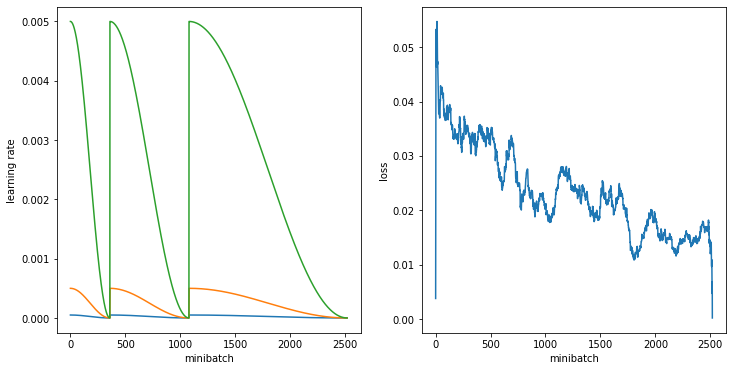

In [19]:
# Different colors for learning rates of different layers in plot on the left
learner.plot_lr_and_loss_sched(smoothing_radius=50)

#### Step 3: 

Resize data and continue training (doing the resizing helps prevent overfitting).

In [20]:
# First reload 'best' model from last training period. 

# Best could mean simply the model with lowest validation loss or highest accuracy. But it is 
# also good to avoid choosing a model that has overfit too much, if we will continue training.
# For epochs 3,4,5,6 there is significant overfitting (i.e. train_loss substantially less than val_loss).
# So, we choose the model from epoch 2 which has train_loss close to val_loss, val_loss fairly low, 
# and accuracy fairly high.
learner.load('224_2')

# Evaluate to check results same as above
learner.evaluate('val')

[0.02077657812833786, 0.9935]

In [21]:
# Now resize to 299 by 299 images
learner.data_resize(299)

In [22]:
# Traing again for 2 cycles of length 2
learner.fit_cycles(lrs,lrs_min,num_cycles=2,base_length=2,save_name='299',save_method='all')

epoch   train_loss  val_loss    accuracy    

0       0.02940     0.01756     0.99450       epoch run time: 2 min, 37.55 sec
1       0.01656     0.01374     0.99700       epoch run time: 2 min, 37.30 sec
2       0.01918     0.01400     0.99600       epoch run time: 2 min, 36.84 sec
3       0.01218     0.01193     0.99750       epoch run time: 2 min, 36.65 sec


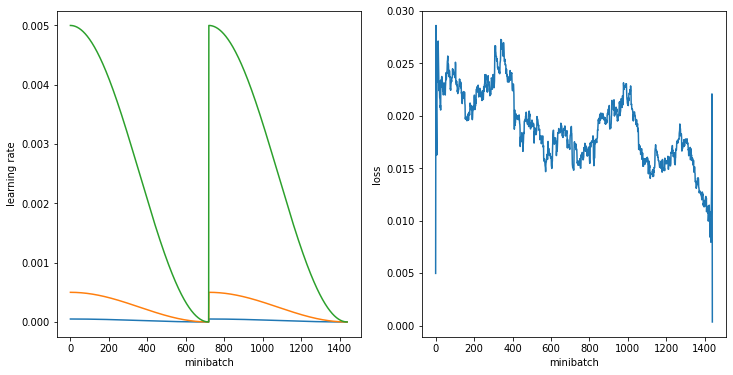

In [23]:
learner.plot_lr_and_loss_sched(smoothing_radius=50)

#### Step 4: 
Use test time augmentation (TTA) to improve our predictions.

In [24]:
# Again, we first select the 'best' model from previous training.
# This time the last model from epoch 3 is clearly the best.
learner.load('299_3')

# Do the TTA
pred_probs, pred_labels = learner.TTA('val')

In [25]:
# Compute Val Loss and Accuracy for TTA predictions
target = learner.data.val_ds.y

loss = learner.loss_func(torch.log(TEN(pred_probs)),TEN(target))
print('val loss =',loss.item())

accuracy = skm.accuracy_score(target,pred_labels)
print('val accuracy =',accuracy)

val loss = 0.009014123119413853
val accuracy = 0.9975


So, the TTA did not actually improve validation accuracy (which was almost perfect already). But it did reduce the val loss.

### Examining Results

Confusion matrix, without normalization
[[997   3]
 [  2 998]]


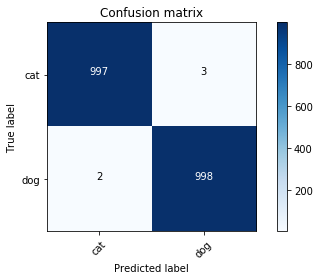

In [26]:
# Confusion Matrix
learner.confusion_matrix(pred_labels)

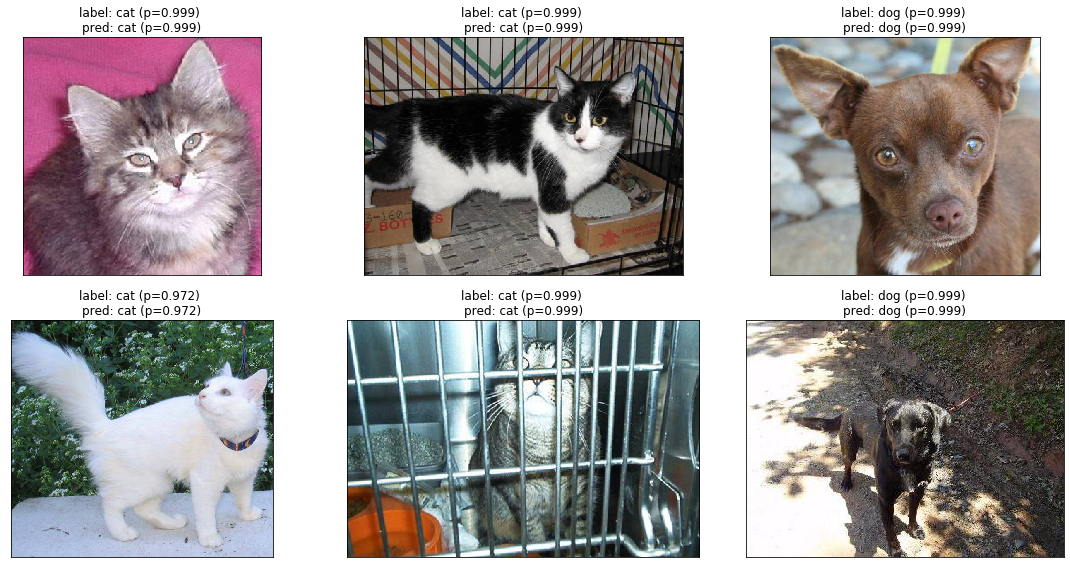

In [27]:
# Show randomly chosen, correctly classified images
learner.show_images('val',classify_type='correct',preds=[pred_probs,pred_labels])

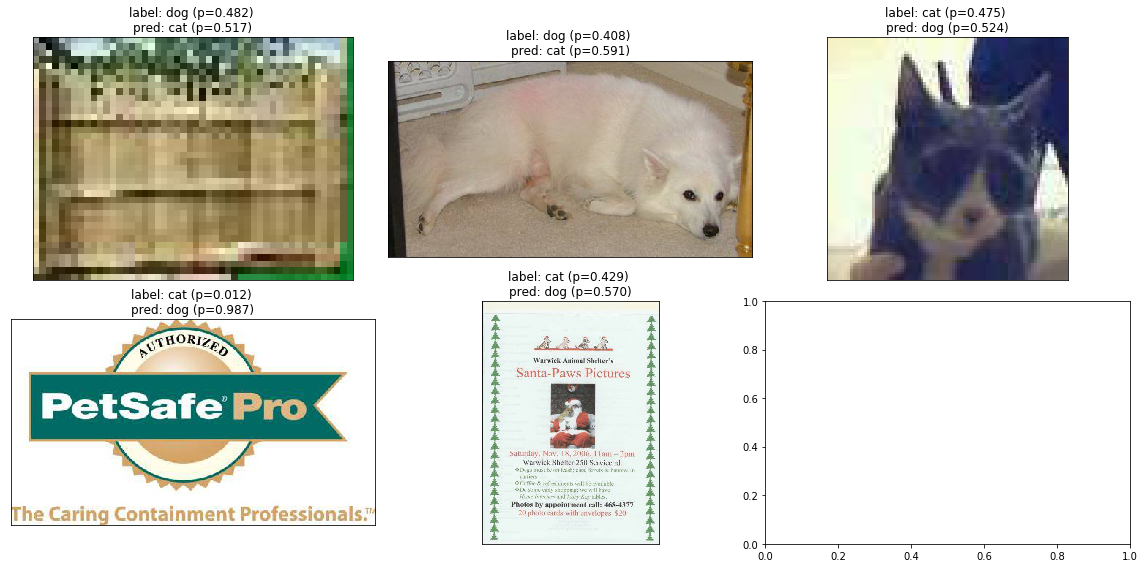

In [28]:
# Show all 5 incorrectly classified images
# (NOTE: Accuracy is 99.75% out of 2000 val images, leaves 5 images incorrect.)
learner.show_images('val',classify_type='incorrect',num_images=5,preds=[pred_probs,pred_labels])

As we can see, all but 2 of these images (top middle and top right), are not well labeled dogs and cats. So, the training procedure worked very well: out of 2000 valid images only 2 are "really" misclassified. 